In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import deque
from neuron import h

import matplotlib
matplotlib.use('Agg')  # causes some error with visualization
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

In [2]:
def set_segments(section):
    try:
        # lambda_f - длина волны на 100 Hz
        lam = section.lambda_f(100)
    except:
        # or default
        lam = 100.0

    # считаем сколько нужно сегментов
    nseg = int(section.L / (0.1 * lam) + 0.999)

    # колво сегментов должно быть нечетным - в neuron уточнение
    if nseg % 2 == 0:
        nseg += 1

    # min - 1
    section.nseg = max(1, nseg)
    

class Network:
    def __init__(self, neuron_ids, neurons_dir='Neurons_Metadata/Graphs/neurons', meta_pkl='Neurons_Metadata/Metadata/Metadata(auto).pkl'):
        self.NEURONS = neuron_ids
        self.NEURONS_DIR = neurons_dir
        self.META_PKL = meta_pkl
        
        self.graphs = {}
        self.sections = {}
        self.somas = {}

        self.synapses = []
        self.t_vec = None
        self.v_records = {}
        
        self.stimulas = []

        print('number of neurons:', len(self.NEURONS), '\n')

    def load_graphs(self):
        print('loading graphs \n')

        for neuron_id in self.NEURONS:
            path = os.path.join(self.NEURONS_DIR, f'{neuron_id}.gml')

            if not os.path.exists(path):
                raise FileNotFoundError(f'{path} not found')

            # read graph
            graph = nx.read_gml(path)
            self.graphs[neuron_id] = graph

            # root - soma
            root_nodes = [n for n, data in graph.nodes(data=True)
                          if data.get('type') == 'root']

            print(f"Neuron {neuron_id}   \t {graph.number_of_nodes()} nodes \t root={root_nodes[0] if root_nodes else 'NONE'}")

    def build_sections(self):
        print('building sections \n')

        for neuron_id, graph in self.graphs.items():

            for node_id, data in graph.nodes(data=True):
                # if soma
                if data.get('type') == 'root':
                    # soma - hh
                    soma = h.Section(name=f"soma_{neuron_id}")

                    soma.L = 20 # длина
                    soma.diam = 20 # диаметр
                    soma.Ra = 100 # аксиальное сопротивление
                    soma.cm = 1 # емкость мембраны

                    soma.insert('hh')

                    soma.gnabar_hh = 0.12 # проводимость натриевых каналов
                    soma.gkbar_hh = 0.036 # проводимость калиевых каналов
                    soma.gl_hh = 0.0003 # leak проводимость
                    soma.el_hh = -54.3

                    # set number of segments
                    set_segments(soma)

                    self.sections[(neuron_id, node_id)] = soma
                    self.somas[neuron_id] = soma
                    break

            # create dendrites
            dendrite_count = 0

            for node_id, data in graph.nodes(data=True):
                node_type = data.get('type')

                if node_type in ('slab', 'branch', 'end'):
                    dend = h.Section(name=f"dend_{neuron_id}_{node_id}")

                    dend.L = 50.0  # длина
                    dend.diam = 2.0  # диаметр
                    dend.Ra = 100.0  # сопротивление
                    dend.cm = 1.0  # емкость

                    # dendrites - passive
                    dend.insert('pas')  # passive механизм
                    dend.g_pas = 0.0001  # пассивная проводимость
                    dend.e_pas = -70.0  # reversal potential

                    set_segments(dend)

                    self.sections[(neuron_id, node_id)] = dend
                    dendrite_count += 1

            print(f'{neuron_id}: {dendrite_count} dendrites')

    def connect_morphology(self):
        print('connecting morphology \n')

        for neuron_id, graph in self.graphs.items():

            morph_nodes = [n for n, d in graph.nodes(data=True) if d.get('type') in ('root', 'slab', 'branch', 'end')]

            # подграф только из этих узлов
            subgraph = graph.subgraph(morph_nodes).to_undirected()

            # находим root
            root = None
            for node in morph_nodes:
                if graph.nodes[node].get('type') == 'root':
                    root = node
                    break

            if not root:
                continue

            # BFS от сомы
            visited = {root}  # visisted nodes
            queue = deque([root])
            connections = 0

            while queue:
                parent_node = queue.popleft()

                for child_node in subgraph.neighbors(parent_node):
                    # if visited -> skip
                    if child_node in visited:
                        continue

                    # get the Neuron section
                    parent_sec = self.sections.get((neuron_id, parent_node))
                    child_sec = self.sections.get((neuron_id, child_node))

                    if parent_sec and child_sec:
                        # соединяем начало ребенка (0) к концу родителя (1)
                        child_sec.connect(parent_sec(1), 0)

                        # отмечаем как посещенный
                        visited.add(child_node)

                        # добавляем в очередь
                        queue.append(child_node)

                        # Увеличиваем счетчик
                        connections += 1

            print(f'{neuron_id}: {connections} connections')

    def build_synapses(self):
        print('building synapses \n')

        meta = pd.read_pickle(self.META_PKL)
        meta = meta.set_index('skeleton_id')
        meta.index = meta.index.astype(str)

        connector_tables = {}

        for neuron_id in self.NEURONS:
            # check if we have it in metadata
            if neuron_id not in meta.index:
                continue

            # get the connectors table for exact skeleton id
            conn_df = meta.loc[neuron_id, 'connectors']

            df = conn_df[['connector_id', 'node_id', 'type']].copy()

            # converting types
            df['connector_id'] = df['connector_id'].astype(int)
            df['node_id'] = df['node_id'].astype(str)

            # 0 - пресинаптик
            # 1 - постсинаптик
            df['bit'] = df['type'].astype(str).str[-1].astype(int)

            connector_tables[neuron_id] = df
            print(f'{neuron_id}: {len(df)} connectors')

        synapse_count = 0

        for i, neuron_a in enumerate(self.NEURONS):
            for neuron_b in self.NEURONS[i + 1:]:

                if neuron_a not in connector_tables or neuron_b not in connector_tables:
                    continue

                # merge таблицы по connector_id
                merged = connector_tables[neuron_a].merge(connector_tables[neuron_b], on='connector_id', suffixes=('_a', '_b'))

                # если нет общих коннекторов - пропускаем
                if len(merged) == 0:
                    continue

                print(f'{neuron_a} <-> {neuron_b}: {len(merged)} shared')

                # Для каждого общего коннектора
                for _, row in merged.iterrows():
                    # получаем 0/1 для каждого нейрона
                    bit_a = int(row['bit_a'])
                    bit_b = int(row['bit_b'])
                    node_a = row['node_id_a']
                    node_b = row['node_id_b']

                    # направление синапса
                    # если A=0 и B=1, то A -> B
                    if bit_a == 0 and bit_b == 1:
                        pre_neuron = neuron_a  # отсюда идет сигнал
                        pre_node = node_a # узел от куда берем
                        post_neuron = neuron_b  # сюда приходит
                        post_node = node_b  # узел где синапс

                    # если A=1 и B=0, то B -> A
                    elif bit_a == 1 and bit_b == 0:
                        pre_neuron = neuron_b
                        pre_node = node_b
                        post_neuron = neuron_a
                        post_node = node_a

                    # если оба 0 или оба 1 - пропускаем
                    else:
                        continue
                    
                    print(f"pre neuron {pre_neuron} ({pre_node}) \t -> \t post neuron {post_neuron} ({post_node})")
                    
                    post_section = self.sections.get((post_neuron, post_node))
                    if not post_section:
                        continue

                    pre_section = self.sections.get((pre_neuron, pre_node))
                    if not pre_section:
                        continue

                    # создаем синапс на постсинаптическом дендрите
                    synapse = h.Exp2Syn(post_section(0.5))  # в центре секции

                    synapse.tau1 = 0.5  # время нарастания
                    synapse.tau2 = 2.0  # время спада
                    synapse.e = 0.0  # reversal potential

                    # создаем детектор спайков - voltage сомы пресинаптика
                    print(pre_section)
                    netcon = h.NetCon(
                        pre_section(0.5)._ref_v,  # откуда берем voltage
                        synapse,  # куда отправляем event
                        sec=pre_section
                    )

                    # Параметры NetCon
                    netcon.threshold = -69.8  # порог (мВ) - спайк когда V > 0
                    netcon.weight[0] = 0.5  # вес синапса (микросименсы)
                    netcon.delay = 3.0  # задержка (ms)

                    # Save synapse and its netcon
                    self.synapses.append([synapse, netcon])
                    synapse_count += 1

        print(f'Synapses created: {synapse_count}')

        
            
    def setup_recording(self, neurons=[], sections=[]):
        print('setting recordings \n')
        # вектор для записи времени
        self.t_vec = h.Vector().record(h._ref_t)

        if len(sections) > 0:
            for section_id in sections:
                # Filter self.sections to find the section that matches the given ID
                section = next((sec for (neuron_id, node_id), sec in self.sections.items() if node_id == section_id), None)
                if section:
                    vec = h.Vector().record(section(0.5)._ref_v)
                    self.v_records[section_id] = vec
                    
        elif len(neurons) > 0:
            for neuron_id in neurons:
                soma = self.somas.get(neuron_id)
                if soma:
                    vec = h.Vector().record(soma(0.5)._ref_v)
                    self.v_records[neuron_id] = vec
        else:
            for neuron_id, soma in self.somas.items():
                vec = h.Vector().record(soma(0.5)._ref_v)
                self.v_records[neuron_id] = vec

                
    def setup_stimulus(self, neurons=None, sections=None, start_time=0, duration=100, amplitude=0.1):
        print('adding stimulus \n')
        if sections:
            for section_id in sections:
                section = next((sec for (neuron_id, node_id), sec in self.sections.items() if node_id == section_id), None)
                if section:
                    stim = h.IClamp(section(0.5))  
                    stim.delay = start_time  
                    stim.dur = duration  
                    stim.amp = amplitude  
                    print(f'Stimulating section {section_id}: {stim.amp} nA for {stim.dur} ms')
        elif neurons:
            for neuron_id in neurons:
                soma = self.somas[neuron_id]
                print(soma)
                if soma:
                    stim = h.IClamp(soma(0.5))  
                    stim.delay = start_time  
                    stim.dur = duration  
                    stim.amp = amplitude 
                    self.stimulas.append(stim)
                    print(f'Stimulating neuron {neuron_id}: {stim.amp} nA for {stim.dur} ms')
        else:
            print("No neurons or sections provided for stimulation.")
            return
    

    def run(self, duration=100):

        print(f'running simulation for {duration}\n')

        h.dt = 0.025  # шаг времени
        h.steps_per_ms = 40  # количество шагов на миллисекунду
        h.v_init = -70  # начальный voltage

        h.finitialize(-70)

        # Run simulation
        h.continuerun(duration)

        print('simulation done \n')

        t = list(self.t_vec)
        voltages = {nid: list(vec) for nid, vec in self.v_records.items()}

        return t, voltages

    def analyze(self, t, voltages):
        print('ANALYZATION \n')

        print("Spikes crossing 0 mV:")
        for neuron_id, v in voltages.items():
            v_array = np.array(v)
            crossings = np.where(v_array > 0)[0]

            if len(crossings) > 0:
                spike_time = t[crossings[0]]
                print(f'{neuron_id}: SPIKE at {spike_time}')
            else:
                print('{neuron_id}: no spike')

        # максимальная деполяризацию
        print('Maximum depolirazation')
        for neuron_id, v in voltages.items():
            v_array = np.array(v)
            baseline = v_array[0]  # начальное значение
            max_v = np.max(v_array)  # максимум
            depol = max_v - baseline  # разница
            print(f'{neuron_id}: {depol} mV')
            
            
    def reset(self):
        h.finitialize(-70)
        h.t = 0
        self.t_vec = None
        self.v_records = {}
        self.stimulas = []


def plot_results(t, voltages):
    plt.figure(figsize=(12, 6))
    # Create a colormap with as many colors as there are voltages to plot
    cmap = matplotlib.cm.get_cmap('viridis')
    num_colors = len(voltages)
    for i, (neuron_id, v) in enumerate(voltages.items()):
        # Generate a color from the colormap
        color = cmap(i / (num_colors - 1) if num_colors > 1 else 0)
        plt.plot(t, v, label=neuron_id, color=color, linewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.title('Network Activity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=10, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()

# Строим Сеть
Это нужно делать один раз и далее проводить уже на ней все симуляции.

Тут мы создаем сеть из нейрона `7594047`, `15741865`. Согласно графу, тут имеется 4 синапсов из первого нейрона во второй (в обратную сторону их нет). По этому далее будем стимулировать `7594047`.
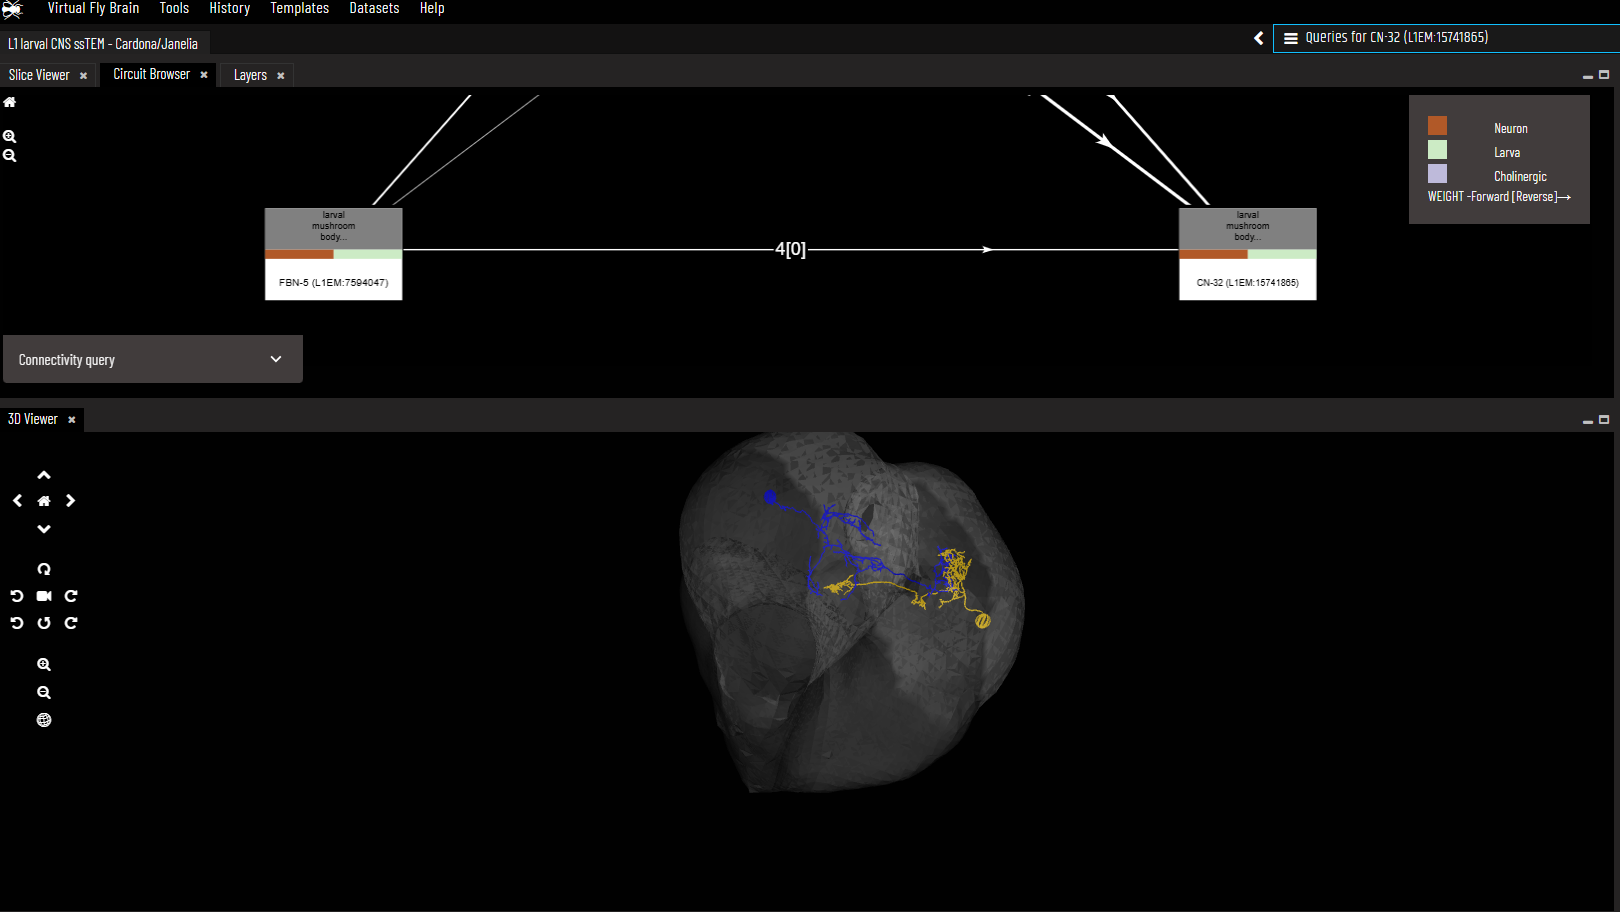


In [3]:
net = Network(['7594047', '15741865'])
net.load_graphs()
net.build_sections()
net.connect_morphology()
net.build_synapses()

number of neurons: 2 

loading graphs 

Neuron 7594047   	 963 nodes 	 root=11261189
Neuron 15741865   	 1200 nodes 	 root=14144925
building sections 

7594047: 605 dendrites
15741865: 770 dendrites
connecting morphology 

7594047: 605 connections
15741865: 770 connections
building synapses 

7594047: 370 connectors
15741865: 454 connectors
7594047 <-> 15741865: 5 shared
pre neuron 7594047 (8869101) 	 -> 	 post neuron 15741865 (15814377)
dend_7594047_8869101
pre neuron 7594047 (15816327) 	 -> 	 post neuron 15741865 (18510351)
dend_7594047_15816327
pre neuron 7594047 (12284139) 	 -> 	 post neuron 15741865 (22443278)
dend_7594047_12284139
pre neuron 7594047 (12284164) 	 -> 	 post neuron 15741865 (18292354)
dend_7594047_12284164
Synapses created: 4


# Запускаем Симуляцию

В этом случае запускаем стимуляцию `7594047` и слушаем сомы обоихнейронов.

### Стимул:

    Начало - 10 (мс)
    
    Длительность - 30 (мс)
    
    Амплитуда - 0.002 (A)
    
    
### Синапсы и NetCon:
    
    Тип - Exp2Syn
    
    Порог Срабатывания - 69.8 (мВ) *это просто чтоб показать работоспособность

    Вес - 0.5 (микросименсы)

    Задержка - 3.0 (мс)
    
p.s. после каждой симуляции сбрасываем состояния.

In [4]:
# Configure the simulation
net.setup_recording(neurons=["7594047", "15741865"])
net.setup_stimulus(neurons=["7594047"], start_time=10, duration=30, amplitude=2)

# запускаем симуляцию
t, voltages = net.run(duration=100)

net.analyze(t, voltages)

net.reset()

setting recordings 

adding stimulus 

soma_7594047
Stimulating neuron 7594047: 2.0 nA for 30.0 ms
running simulation for 100

simulation done 

ANALYZATION 

Spikes crossing 0 mV:
7594047: SPIKE at 10.549999999999935
{neuron_id}: no spike
Maximum depolirazation
7594047: 112.93945614141697 mV
15741865: 3.265106679680727 mV


# Рассмотрим Активность на Произвольних Участках Каждого Нейрона

Нарисуем 2 графика: активность произвольных секций нейрона `7594047` и активность произвольных секций нейрона `15741865` (для удобства просто проведем 2 симуляции с разными рекордерами).

На первом графике, первый нейрон (который стимулируется) выдает 4-5 спайков, которые "размазывает" по времени и амплитуде, в зависимости от сегмента, который рассматриваем. Так до сегментов доходит очень слабый потенциал < -66 мв.

На втором графике, второй нейрон (который принимает) получает синаптический ток от первого нейрона. По видимому, амплитуды первого нейрона хватило только на одно срабатывание синапса (первый импульс самый мощный).

setting recordings 

adding stimulus 

soma_7594047
Stimulating neuron 7594047: 2.0 nA for 30.0 ms
running simulation for 100

simulation done 



/tmp/ipykernel_151318/4167731760.py:386: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


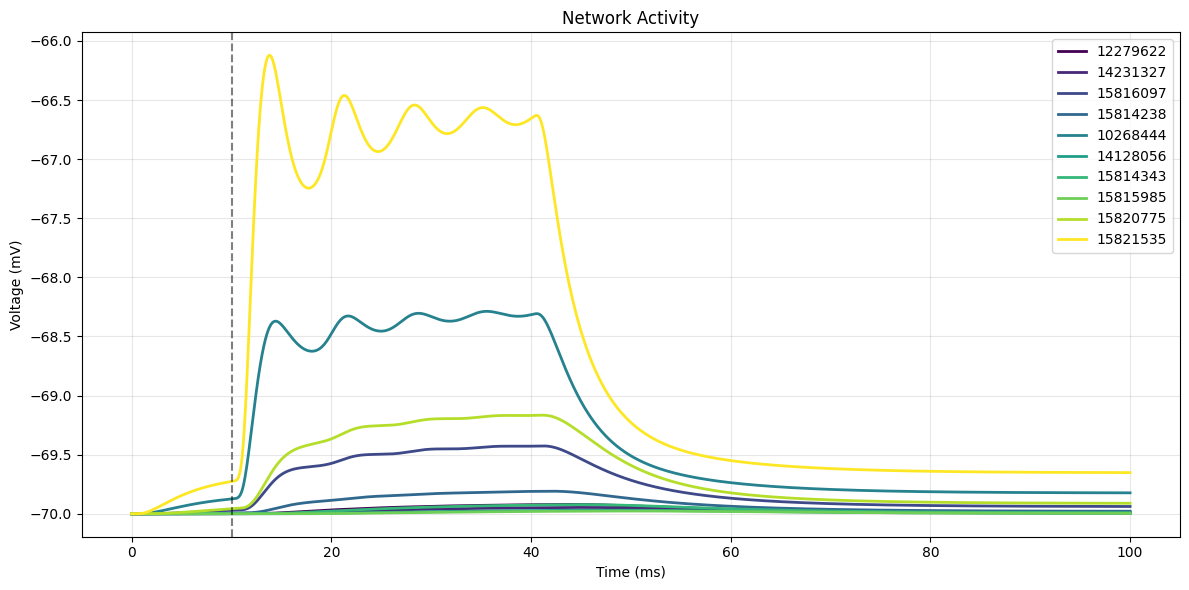

In [5]:
# это для нейрона 7594047
n1_sections=["12279622", "14231327", "15816097", "15814238", "10268444", "14128056", "15814343", "15815985", "15820775", "15821535"]

# Configure the simulation
net.setup_recording(sections=n1_sections)
net.setup_stimulus(neurons=["7594047"], start_time=10, duration=30, amplitude=2)

# запускаем симуляцию
t, voltages = net.run(duration=100)
plot_results(t, voltages)
net.reset()

setting recordings 

adding stimulus 

soma_7594047
Stimulating neuron 7594047: 2.0 nA for 30.0 ms
running simulation for 100

simulation done 



/tmp/ipykernel_151318/4167731760.py:386: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


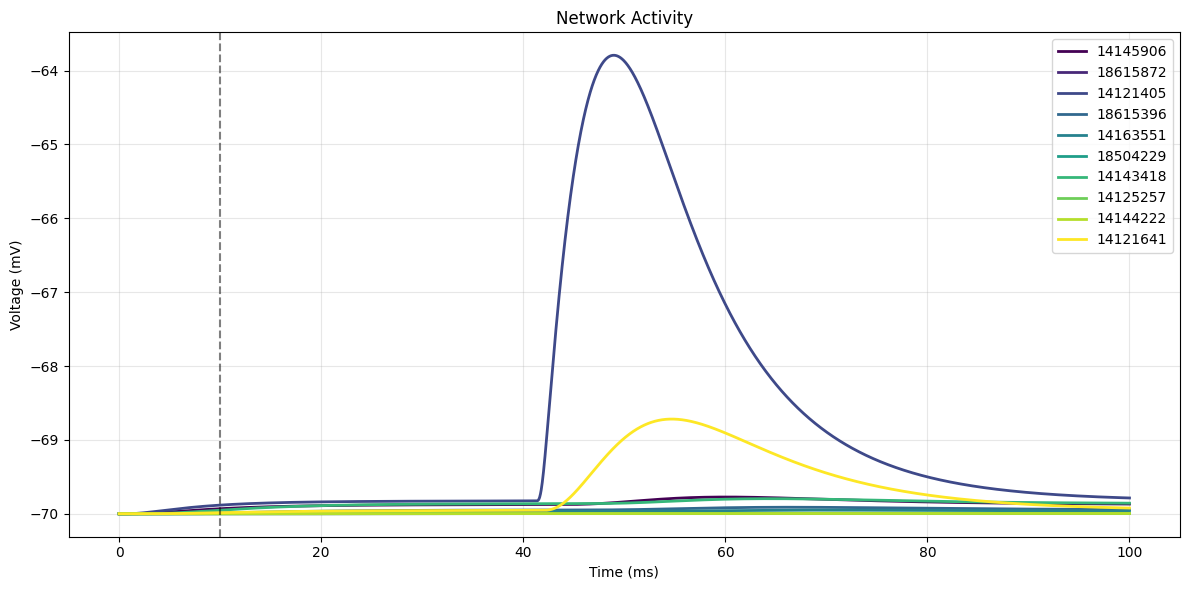

In [6]:
# это для нейрона 15741865
n2_sections=["14145906", "18615872", "14121405", "18615396", "14163551", "18504229", "14143418", "14125257", "14144222", "14121641"]

# Configure the simulation
net.setup_recording(sections=n2_sections)
net.setup_stimulus(neurons=["7594047"], start_time=10, duration=30, amplitude=2)

# запускаем симуляцию
t, voltages = net.run(duration=100)
plot_results(t, voltages)
net.reset()

# Рассмотрим Активность Прямо на Pre/Post Синаптических Сегментах

Посмотрим на второй по счету синапс, ибо он ближе вс его к соме стимулируемого нейрона.

На графике pre (`12284139`) и post (`22443278`) ноды прямо между синапсом. Видно, что post синапс отработал, а pre как буд-то пустой, но это не так. Если приблизить, то там видно, что дошел слабый сигнал (собственно -69.8 мВ) который и тригернул синапс. Собственно по этому, из-за масштаба не видно pre активность.

setting recordings 

adding stimulus 

soma_7594047
Stimulating neuron 7594047: 2.0 nA for 30.0 ms
running simulation for 100

simulation done 



/tmp/ipykernel_151318/4167731760.py:386: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


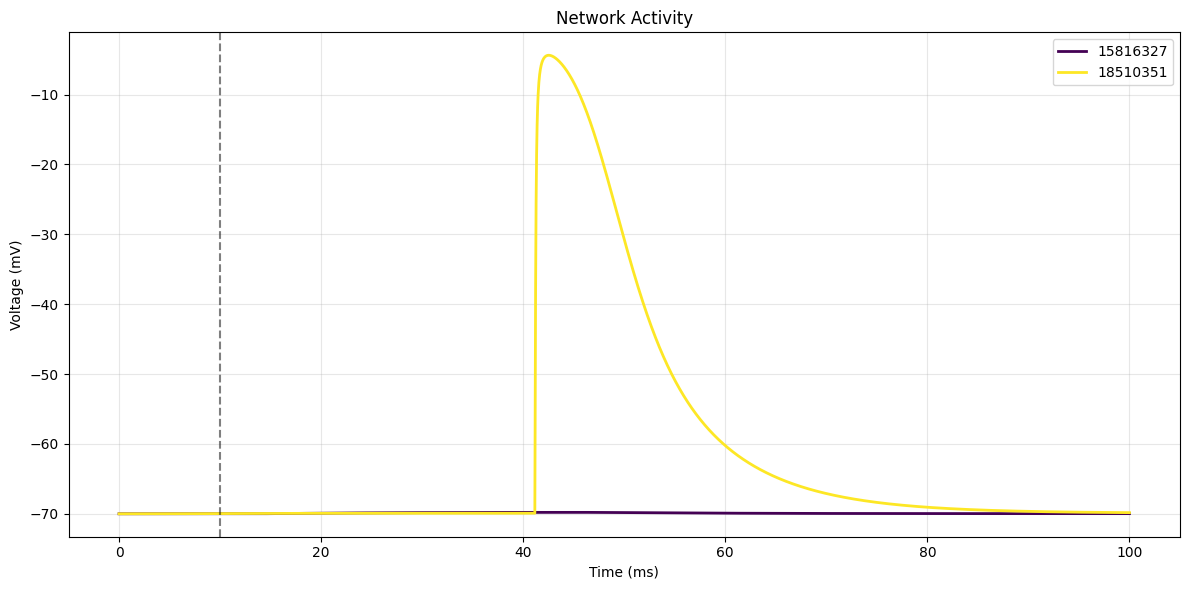

In [7]:
# Test synapses
# syn_1_sections=["8869101", "15814377"]
syn_2_sections=["15816327", "18510351"]
# syn_3_sections=["12284139", "22443278"]
# syn_4_sections=["12284164", "18292354"]


# Configure the simulation
net.setup_recording(sections=syn_2_sections)
net.setup_stimulus(neurons=["7594047"], start_time=10, duration=30, amplitude=2)

# запускаем симуляцию
t, voltages = net.run(duration=100)
plot_results(t, voltages)
net.reset()